In [31]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data prepration

In [32]:
df = pd.read_csv("/content/wind_dataset.csv")

In [33]:
df.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


In [34]:
df['DATE']=pd.to_datetime(df['DATE'])

In [35]:
df.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


<Axes: xlabel='DATE'>

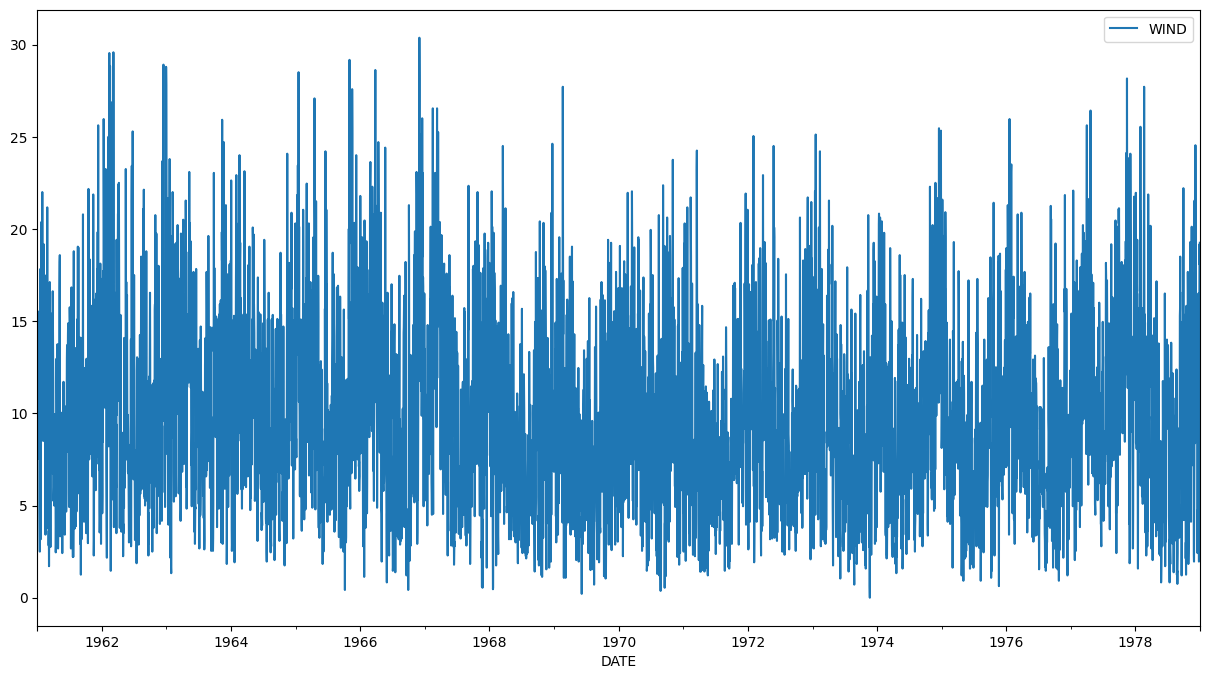

In [36]:
df.plot(x='DATE',y='WIND',figsize=(15,8))

<ipython-input-37-712c7117188d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(method='kendall'),annot=True, cbar=False, cmap='Blues', fmt='.1f')


<Axes: >

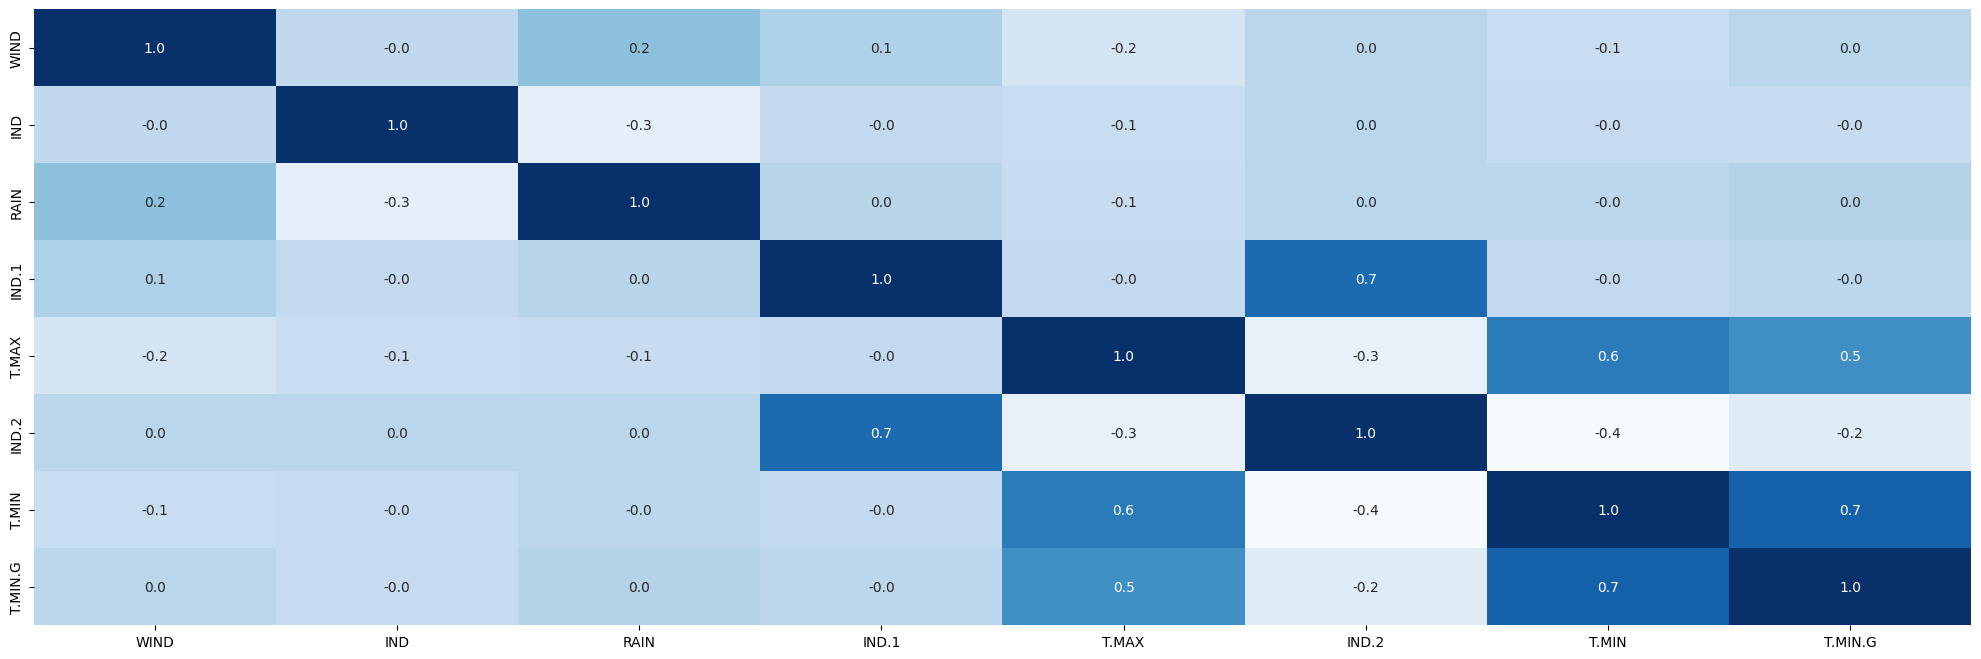

In [37]:
plt.figure(figsize=(25,8))
sns.heatmap(df.corr(method='kendall'),annot=True, cbar=False, cmap='Blues', fmt='.1f')

In [38]:
df=df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   DATE     6574 non-null   datetime64[ns]
 1   WIND     6574 non-null   float64       
 2   IND      6574 non-null   int64         
 3   RAIN     6574 non-null   float64       
 4   IND.1    6574 non-null   float64       
 5   T.MAX    6574 non-null   float64       
 6   IND.2    6574 non-null   float64       
 7   T.MIN    6574 non-null   float64       
 8   T.MIN.G  6574 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 462.4 KB


<Axes: >

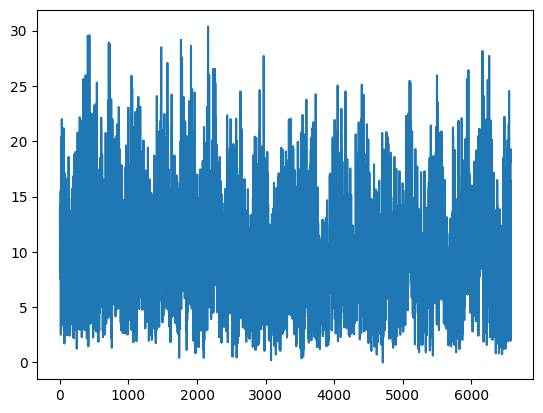

In [40]:
wind = df['WIND']
wind.plot()

# Split as Time series

In [39]:
def df_to_X_y (df,future, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+future]
    y.append(label)
  return np.array(X), np.array(y)

In [42]:
WINDOW_SIZE = 10
future = 1
X1, y1 = df_to_X_y(wind,future, WINDOW_SIZE)
X1.shape, y1.shape

((6564, 10, 1), (6564,))

In [54]:
6564*0.7

4594.799999999999

In [44]:
X_train1, y_train1 = X1[:4600], y1[:4600]
X_val1, y_val1 = X1[4600:5000], y1[4600:5000]
X_test1, y_test1 = X1[5000:], y1[5000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((4600, 10, 1), (4600,), (400, 10, 1), (400,), (1564, 10, 1), (1564,))

# Modeling

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((10, 1)))
model1.add(LSTM(150))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 150)               91200     
                                                                 
 dense_4 (Dense)             (None, 8)                 1208      
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 92417 (361.00 KB)
Trainable params: 92417 (361.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:

cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [48]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=20, callbacks=[cp1])

Epoch 1/20
144/144 [==============================] - 10s 52ms/step - loss: 98.4515 - root_mean_squared_error: 9.9223 - val_loss: 39.1647 - val_root_mean_squared_error: 6.2582
Epoch 2/20
144/144 [==============================] - 6s 45ms/step - loss: 34.4412 - root_mean_squared_error: 5.8687 - val_loss: 18.9803 - val_root_mean_squared_error: 4.3566
Epoch 3/20
144/144 [==============================] - 7s 51ms/step - loss: 22.6856 - root_mean_squared_error: 4.7629 - val_loss: 14.0640 - val_root_mean_squared_error: 3.7502
Epoch 4/20
144/144 [==============================] - 6s 41ms/step - loss: 15.7667 - root_mean_squared_error: 3.9707 - val_loss: 6.6555 - val_root_mean_squared_error: 2.5798
Epoch 5/20
144/144 [==============================] - 8s 56ms/step - loss: 9.1516 - root_mean_squared_error: 3.0252 - val_loss: 4.4486 - val_root_mean_squared_error: 2.1092
Epoch 6/20
144/144 [==============================] - 6s 43ms/step - loss: 6.8201 - root_mean_squared_error: 2.6115 - val_loss:

In [49]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

# Evaluation

In [50]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

144/144 [==============================] - 2s 7ms/step


,Train Predictions,Actuals
0,11.427842,11.50
1,11.117064,11.25
2,8.698045,8.63
3,11.775346,11.92
4,10.603287,10.67
...,...,...
4595,5.243313,5.41
4596,7.759119,7.79
4597,11.632996,11.83
4598,8.486270,8.38


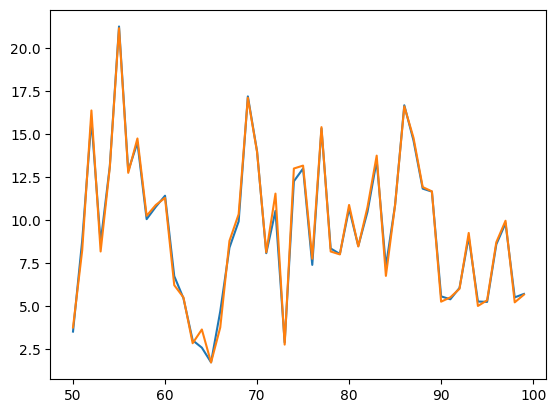

In [51]:

plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [52]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals(test)':y_test1})
test_results

49/49 [==============================] - 0s 7ms/step


,Test Predictions,Actuals(test)
0,9.083327,9.13
1,9.429967,9.42
2,10.505537,10.37
3,5.616440,5.46
4,2.945099,2.79
...,...,...
1559,2.438704,2.42
1560,3.856622,4.75
1561,4.414809,4.54
1562,8.778857,11.67


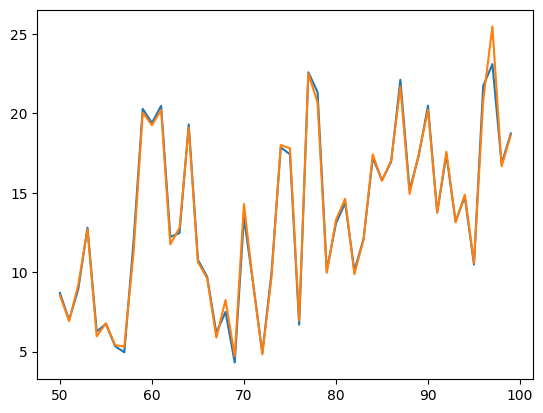

In [53]:

plt.plot(test_results['Test Predictions'][50:100])
plt.plot(test_results['Actuals(test)'][50:100])